# Setup

Perform all necessary imports up front

In [8]:
!pip install --quiet --quiet armory-library armory-examples[cv]

5268.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [9]:
%matplotlib inline

# armory-library imports
import armory.engine
import armory.evaluation
import armory.results
import armory.utils

# armory-examples imports
import armory.examples.image_classification.food101 as food101

/home/jay/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Evaluation

In [10]:
evaluation = armory.evaluation.Evaluation(
    name="image-classification-food101",
    description="Image classification of food-101",
    author="TwoSix",
)

## Model

From our `food101` example, we will load a model from HuggingFace that has
already been fine-tuned on the food-101 dataset. We also wrap this model in an
Adversarial Robustness Toolbox (ART) estimator so that we can use an ART attack
against the model.

In [11]:
with evaluation.autotrack():
    model, art_estimator = food101.load_model()
evaluation.use_model(model)

/home/jay/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jay/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:843: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


## Dataset

From our `food101` example, we will load the food-101 dataset from HuggingFace.

In order to get a variety of classes in this demonstration, we're shuffling the
dataset with a fixed seed.

In [12]:
with evaluation.autotrack():
    dataset, labels = food101.load_huggingface_dataset(batch_size=2, shuffle=True, seed=8675309)
evaluation.use_dataset(dataset)

Generating validation split: 100%|██████████| 25250/25250 [00:01<00:00, 13849.70 examples/s]


## Attack

From our `food101` example, we create a Projected Gradient Descent (PGD) attack
using the Adversarial Robustness Toolbox (ART).

In [13]:
with evaluation.autotrack():
    attack = food101.create_pgd_attack(art_estimator)

## Metrics

From our `food101` example, we create the metrics to be collected during the
evaluation. These include an L-infinity norm distance between unperturbed and
perturbed input, and a categorical accuracy between the natural labels and the
predicted labels.

In [14]:
evaluation.use_metrics(
    food101.create_metrics()
)

## Exporters

From our `food101` example, we create the exporters used to record sample images
during the evaluation.

In [15]:
evaluation.use_exporters(
    food101.create_exporters(model, export_every_n_batches=1)
)

## Evaluation Chains

We will define two perturbation chains: `benign` and `attack`. The benign chain
does not apply any perturbations to the data, giving us the intrinsic
performance of the model. The attack chain will give us the performance of the
model under adversarial attack.

In [16]:
with evaluation.add_chain("benign"):
    pass

with evaluation.add_chain("attack") as chain:
    chain.add_perturbation(attack)

# Execute the Evaluation

We create an evaluation engine which will handle the application of all
perturbations, obtaining predictions from the model, collecting metrics, and
exporting of samples.

In [17]:
engine = armory.engine.EvaluationEngine(
    evaluation,
    limit_test_batches=2,
)
results = engine.run()
chains = [results.children["benign"], results.children["attack"]]

Experiment with name image-classification-food101 not found. Creating it.
2024/09/17 18:19:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/09/17 18:19:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/home/jay/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024/09/17 18:19:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/09/17 18:19:35 INFO mlflow.system_metrics.system_metrics_monitor: Star

Testing DataLoader 0: 100%|██████████| 2/2 [00:21<00:00,  0.10it/s]

2024/09/17 18:19:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/09/17 18:19:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


/home/jay/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024/09/17 18:19:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/09/17 18:19:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
/home/jay/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/jay/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many w

Testing DataLoader 0: 100%|██████████| 2/2 [01:45<00:00,  0.02it/s]

2024/09/17 18:21:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/09/17 18:21:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/09/17 18:21:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/09/17 18:21:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [18]:
armory.results.plot_metrics(*chains)

Metric,benign,attack
accuracy,1.000,0.500
epoch,0.000,0.000
linf_norm,0.000,0.003
precision,1.000,0.333
recall,1.000,0.333


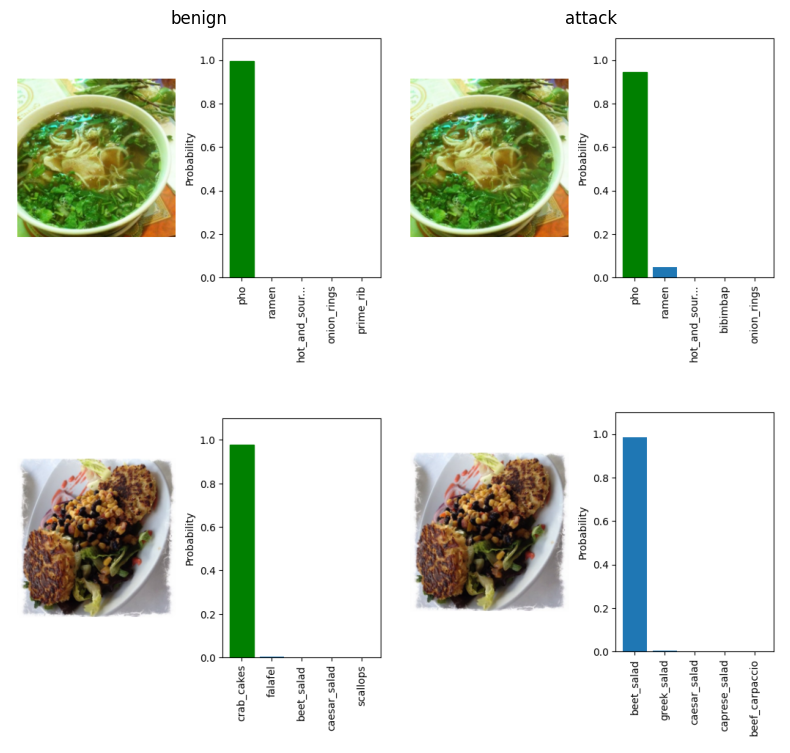

In [19]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(0).sample(sample_idx).classification.plot(labels=labels, top_k=5)
            for chain in chains
        ]
        for sample_idx in range(2)
    ],
    columns=[chain.run_name for chain in chains],
    figsize=(8, 8),
)

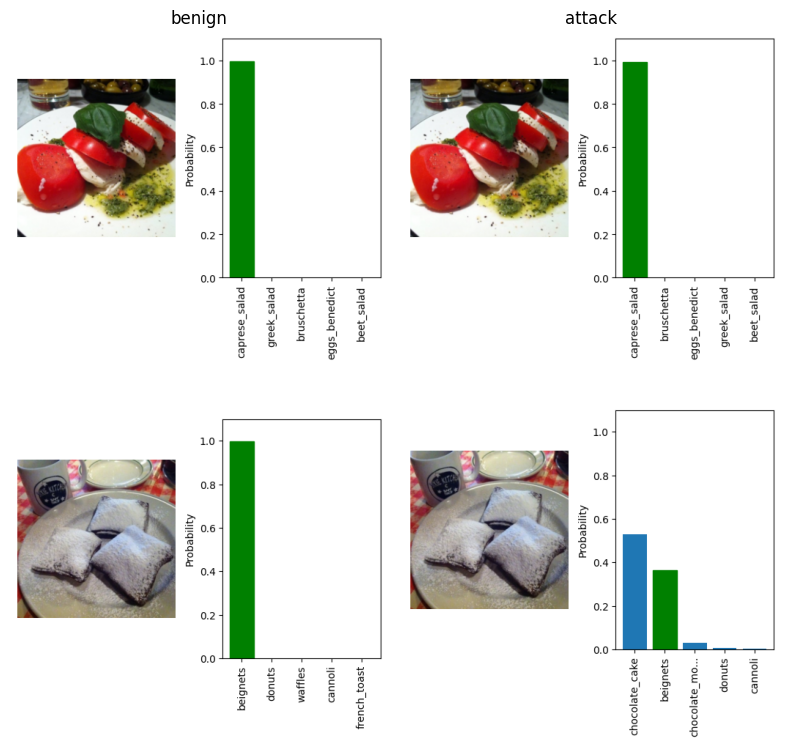

In [20]:
armory.results.plot_in_grid(
    [
        [
            chain.batch(1).sample(sample_idx).classification.plot(labels=labels, top_k=5)
            for chain in chains
        ]
        for sample_idx in range(2)
    ],
    columns=[chain.run_name for chain in chains],
    figsize=(8, 8),
)

# Additional Code

In order to make this notebook concise some helper functions have been imported
from [armory.examples.image_classification.food101](https://github.com/twosixlabs/armory-library/blob/master/examples/src/armory/examples/image_classification/food101.py)
